In [ ]:
!pip install pulp pandas numpy matplotlib scikit-learn tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 116.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# --- constants ---
mass = 1500            # kg
air_density = 1.225    # kg/m3
drag_coeff = 0.29
frontal_area = 2.2     # m2
rolling_resistance = 0.015
wheel_radius = 0.3     # m
gear_efficiency = 0.97
g = 9.81
battery_capacity = 40  # kWh


In [ ]:
def generate_realistic_profile(duration_s=600):
    """Create a smooth, realistic synthetic driving profile."""
    t = np.arange(0, duration_s, 1)
    speed = (
        60 + 30 * np.sin(2 * np.pi * t / 120) +
        10 * np.sin(2 * np.pi * t / 45)
    )
    speed = np.clip(speed, 0, 120)

    slope = 2 * np.sin(2 * np.pi * t / 300)          # mild hills
    ambient_temp = 25 + 3 * np.sin(2 * np.pi * t / 500)
    battery_temp = ambient_temp + 2
    gear_ratio = 9 - 0.04 * speed                    # lower ratio at high speed
    road_cond = np.full_like(speed, 0.015)           # constant rolling resistance

    df = pd.DataFrame({
        "time_s": t,
        "speed": speed,
        "slope": slope,
        "gear_ratio": gear_ratio,
        "ambient_temp": ambient_temp,
        "battery_temp": battery_temp,
        "road_condition": road_cond
    })
    return df


In [ ]:
def EVPM_from_dataset(df):
    """Compute EV power, torque, energy, and SOC using physics equations."""
    v = df["speed"].values / 3.6
    accel = np.gradient(v)
    theta = np.deg2rad(df["slope"].values)
    gear_ratio = df["gear_ratio"].values
    road_cond = df["road_condition"].values
    amb_temp = df["ambient_temp"].values
    batt_temp = df["battery_temp"].values

    # Forces
    F_aero = 0.5 * air_density * drag_coeff * frontal_area * v**2
    F_roll = mass * g * road_cond * np.cos(theta)
    F_slope = mass * g * np.sin(theta)
    F_accel = mass * accel
    F_total = F_aero + F_roll + F_slope + F_accel

    # Torque and power
    torque = F_total * wheel_radius / (gear_ratio * gear_efficiency)
    P_mech = F_total * v / 1000  # kW mechanical

    # Efficiencies and electrical power
    eta_motor = 0.9 - 0.05 * np.tanh((torque - 100) / 200)
    eta_inv = 0.96
    eta_total = eta_motor * eta_inv * gear_efficiency
    P_elec = P_mech / np.maximum(eta_total, 0.7)
    temp_factor = 1.0 - 0.002 * np.abs(amb_temp - 25)
    P_elec_adj = P_elec / temp_factor
    P_elec_adj = np.clip(P_elec_adj, 0, None)

    # Integrate energy and SOC
    energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
    soc_used = energy_kWh / battery_capacity
    distance = np.cumsum(v) / 1000
    soc_profile = 1.0 - np.cumsum(P_elec_adj) / 3600 / battery_capacity
    soc_profile = np.clip(soc_profile, 0, 1)

    # Attach computed columns
    df["distance"] = distance
    df["acceleration"] = accel
    df["torque"] = torque
    df["SOC_prev"] = soc_profile
    df["power_kW"] = P_elec_adj
    return df, soc_used


In [ ]:
def build_dataset(n_trips=200, duration=600, add_variability=False):
    sequences, labels = [], []
    for _ in range(n_trips):
        profile = generate_realistic_profile(duration)

        if add_variability:
            profile["speed"] *= np.random.uniform(0.95, 1.05)
            profile["slope"] += np.random.uniform(-0.2, 0.2)
            profile["ambient_temp"] += np.random.uniform(-2, 2)

        df_evpm, soc_used = EVPM_from_dataset(profile)
        features = [
            "distance","speed","acceleration","slope","torque",
            "gear_ratio","ambient_temp","battery_temp","road_condition","SOC_prev"
        ]
        sequences.append(df_evpm[features].values.astype("float32"))
        labels.append(soc_used)
    return sequences, np.array(labels, dtype="float32")

In [ ]:
def build_dataset(n_trips=200, duration=600, add_variability=False):
    sequences, labels = [], []
    for _ in range(n_trips):
        profile = generate_realistic_profile(duration)

        if add_variability:

            profile["speed"] *= np.random.uniform(0.8, 1.2)          # ±20% variation
            profile["slope"] += np.random.uniform(-1.5, 1.5)         # ±1.5° slope shift
            profile["ambient_temp"] += np.random.uniform(-10, 10)    # cold/hot weather
            profile["road_condition"] *= np.random.uniform(0.8, 1.3) # wet/rough road
            profile["gear_ratio"] *= np.random.uniform(0.9, 1.1)     # different transmission setup

        df_evpm, soc_used = EVPM_from_dataset(profile)
        features = [
            "distance","speed","acceleration","slope","torque",
            "gear_ratio","ambient_temp","battery_temp","road_condition","SOC_prev"
        ]
        sequences.append(df_evpm[features].values.astype("float32"))
        labels.append(soc_used)
    return sequences, np.array(labels, dtype="float32")


In [ ]:
sequences, y = build_dataset(300, 600)
maxlen = max(len(seq) for seq in sequences)
num_features = sequences[0].shape[1]

X_padded = pad_sequences(sequences, maxlen=maxlen, dtype="float32", padding="post", value=0.0)
scaler = MinMaxScaler()
flat = X_padded.reshape(-1, num_features)
flat_scaled = scaler.fit_transform(flat)
X_scaled = flat_scaled.reshape(X_padded.shape)

split = int(0.8 * X_scaled.shape[0])
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y[:split], y[split:]

print("Training set:", X_train.shape, "Testing set:", X_test.shape)

/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of th

Training set: (240, 600, 10) Testing set: (60, 600, 10)


/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of th

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(maxlen, num_features)),
    tf.keras.layers.Masking(mask_value=0.0),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse',
              metrics=['mae'])

model.summary()
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=40,
                    batch_size=16,
                    verbose=1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 600, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,489 (310.50 KB)

 Trainable params: 79,489 (310.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0149 - mae: 0.1048 - val_loss: 0.0026 - val_mae: 0.0506
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0013 - mae: 0.0320 - val_loss: 4.0866e-04 - val_mae: 0.0202
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.2334e-04 - mae: 0.0165 - val_loss: 1.8526e-05 - val_mae: 0.0043
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.1658e-05 - mae: 0.0076 - val_loss: 1.5318e-06 - val_mae: 0.0012
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9799e-05 - mae: 0.0038 - val_loss: 4.0514e-06 - val_mae: 0.0020
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.9616e-06 - mae: 0.0024 - val_loss: 5.1255e-06 - val_mae: 0.0023
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.6611e-06 - mae: 0.0015 - val_loss: 4.8746e-07 - val_mae: 6.9819e-04
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.1245e-07 - mae: 6.5104e-04 - val_loss: 3.9084e-07 - val_mae: 6.2517e-04


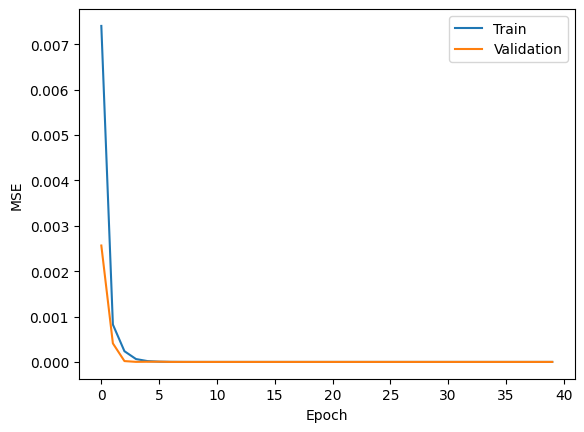

Test MSE: 0.000000   MAE: 0.000000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


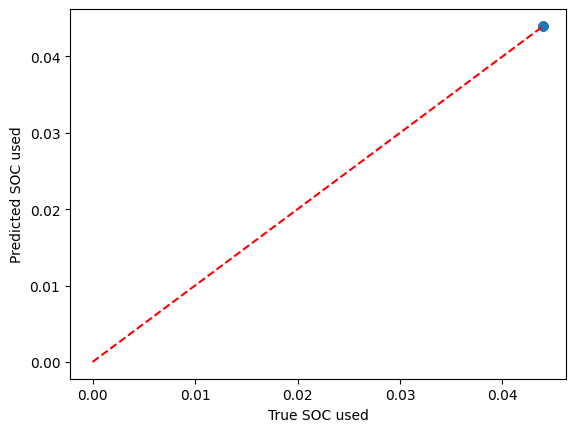

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.6f}   MAE: {test_mae:.6f}")

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True SOC used"); plt.ylabel("Predicted SOC used")
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.show()


/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_kWh = np.trapz(P_elec_adj, dx=1) / 3600
/tmp/ipython-input-259169792.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of th

Starting real-time monitoring and adaptive retraining...
Batch 01 | MAPE: 9.05% | Rolling Avg: 9.05%
Batch 02 | MAPE: 16.46% | Rolling Avg: 12.75%
Batch 03 | MAPE: 3.74% | Rolling Avg: 9.75%
Batch 04 | MAPE: 4.83% | Rolling Avg: 8.52%
Batch 05 | MAPE: 1.70% | Rolling Avg: 6.68%
Batch 06 | MAPE: 12.32% | Rolling Avg: 5.65%
⚠️  MAPE spike detected (12.32%), retraining model on recent data...
✅ Model retrained and updated.

Batch 07 | MAPE: 1.45% | Rolling Avg: 5.07%
Batch 08 | MAPE: 2.09% | Rolling Avg: 4.39%
Batch 09 | MAPE: 6.09% | Rolling Avg: 5.49%
Batch 10 | MAPE: 0.33% | Rolling Avg: 2.49%
Batch 11 | MAPE: 6.75% | Rolling Avg: 3.82%
Batch 12 | MAPE: 2.99% | Rolling Avg: 4.04%
Batch 13 | MAPE: 5.48% | Rolling Avg: 3.89%
Batch 14 | MAPE: 0.29% | Rolling Avg: 3.88%
Batch 15 | MAPE: 8.66% | Rolling Avg: 4.36%
Batch 16 | MAPE: 9.85% | Rolling Avg: 6.07%
Batch 17 | MAPE: 5.85% | Rolling Avg: 6.16%
Batch 18 | MAPE: 0.98% | Rolling Avg: 6.33%
Batch 19 | MAPE: 1.90% | Rolling Avg: 4.64%
Bat

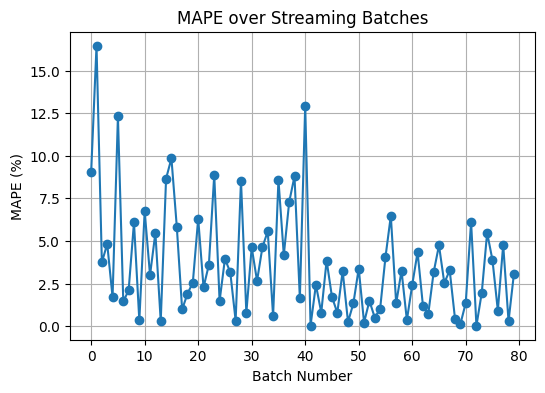

In [ ]:



def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


MAPE_THRESHOLD = 5.0     # retrain if MAPE increases by >5%
BATCH_SIZE = 1          # number of trips per monitoring batch
EPOCHS_ON_RETRAIN = 10   # short retraining burst


stream_sequences, stream_labels = build_dataset(n_trips=80, duration=600, add_variability=True)


flat_mape_history = []
recent_batches_X, recent_batches_y = [], []

print("Starting real-time monitoring and adaptive retraining...")

for i in range(0, len(stream_sequences), BATCH_SIZE):
    batch_X = stream_sequences[i:i+BATCH_SIZE]
    batch_y_true = stream_labels[i:i+BATCH_SIZE]

    # preprocess batch
    batch_X_pad = pad_sequences(batch_X, maxlen=X_train.shape[1], dtype="float32", padding="post", value=0.0)
    flat = batch_X_pad.reshape(-1, batch_X_pad.shape[2])
    batch_X_scaled = scaler.transform(flat).reshape(batch_X_pad.shape)

    # predict
    batch_y_pred = model.predict(batch_X_scaled, verbose=0).flatten()

    # compute MAPE
    mape_val = MAPE(batch_y_true, batch_y_pred)
    flat_mape_history.append(mape_val)

    # Track recent batches for possible retraining
    recent_batches_X.append(batch_X_scaled)
    recent_batches_y.append(batch_y_true)

    # moving average MAPE (last 4 batches)
    if len(flat_mape_history) >= 4:
        avg_mape = np.mean(flat_mape_history[-4:])
    else:
        avg_mape = np.mean(flat_mape_history)

    print(f"Batch {i//BATCH_SIZE+1:02d} | MAPE: {mape_val:.2f}% | Rolling Avg: {avg_mape:.2f}%")

    # Adaptive retraining trigger
    if mape_val > avg_mape + MAPE_THRESHOLD:
        print(f"⚠️  MAPE spike detected ({mape_val:.2f}%), retraining model on recent data...")
        # gather last few batches for fine-tuning
        X_recent = np.concatenate(recent_batches_X[-3:], axis=0)
        y_recent = np.concatenate(recent_batches_y[-3:], axis=0)
        model.fit(X_recent, y_recent, epochs=EPOCHS_ON_RETRAIN, batch_size=8, verbose=0)
        print("✅ Model retrained and updated.\n")

# Plot MAPE evolution
plt.figure(figsize=(6,4))
plt.plot(flat_mape_history, marker='o')
plt.title("MAPE over Streaming Batches")
plt.xlabel("Batch Number")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()
